<h1>DEEP-EMOTIVE</h1>
<h2>Trabalho de conclusão de curso - Ciência da Computação  - FURB - 2017</h2>
<h3>Autor: Diogenes Ademir Domingos<br>
 Modulo de treinamento da rede neural profunda</h3>

<p>Deep-Emotive é um protótipo para reconhecer e classificar as expressões faciais das emoções, alegria, desgosto, medo, raiva, surpresa, tristeza, consideradas por Ekman et al. (1987), como básicas e universais, utilizando técnicas já consolidadas das áreas de Processamento Digital de Imagem e Visão Computacional. Estas técnicas são combinadas com uma nova abordagem, considerada a mais avançada no reconhecimento visual de objetos através do aprendizado de máquina, o Aprendizado Profundo ou Deep Learning.</p><br>
<p>O trabalho desenvolvido implementou um classificador de emoções capaz de reconhecer oito emoções, alcançando 96,33%. As duas emoções reconhecidas e que não estavam na proposta inicial são desprezo e neutra.</p>

<p>Adicionalmente, foi implementada a técnica de Transferência de Aprendizado, com o objetivo de validar o aprendizado obtido pelo classificador de emoções proposto, bem como para investigar suas limitações.
Foi utilizado para esta técnica as bases de dados:
<ul>
  <li><a href="https://github.com/diogensd/deepemotive/transferencia_aprendizado_jaffe.html">
    Japanese Female Facial Expression (JAFFE)</a>, atingindo uma precisão de 93,02%.</li>
  <li><a href="https://github.com/diogensd/deepemotive/transferencia_aprendizado_fer2013.html">
    Facial Expression Recognition 2013 (FER-2013)</a>, alcançando 60,62% de precisão </li>
</ul>
</p>

<p>Os resultados obtidos foram satisfatórios quando aplicado a transferência de aprendizado na base de dados JAFFE, atingindo uma precisão de 93,02%. No entanto o protótipo apresentou baixa assertividade, alcançado 60,62% de precisão na base de dados FER-2013. Uma das razões da baixa assertividade é que a base de dados FER-2013 possui imagens dissimilares às bases de dados citadas anteriormente, contendo imagens com problemas que ainda são desafiadores para a área de visão computacional, como oclusão e ruido. No entanto, o resultado foi superior à taxa de escolha randômica de 50%.</p>

In [140]:
# Bibliotecas necessárias para execução do módulo de detecção da face
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import itertools
from IPython.display import display, HTML

# Modulo para trabalhar com de coleções em forma de dicionarios
from collections import OrderedDict

# Referência: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

# biblioteca para trabalhar com imagens
from PIL import Image, ImageEnhance

# Scikitlearn
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split #cross_validation is deprecated

# Configunrando o framework Keras.

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando modelo para salvar e importar a DNN
from keras.models import model_from_json, load_model

# Importando o tipo de camada
from keras.layers import Input,Dense

from keras.layers import merge

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importando modulo para explrar as camadas do modelo
from keras.models import Model

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo para trabalhar com as bordas da imagem (https://keras.io/layers/convolutional/#zeropadding2d)
from keras.layers.convolutional import ZeroPadding2D

# Importando modulo para normalizar a imagem (https://keras.io/layers/convolutional/#zeropadding2d)
from keras.layers.normalization import BatchNormalization

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

from keras.layers.pooling import AveragePooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

# modulo para trabalhar reprocessar as imagens
from keras.preprocessing import image

# modulo de utilizades para trabalhar reprocessar as imagens
from keras.utils.data_utils import get_file

# modulo de callback para parar o treinamento na melhor opção
from keras.callbacks import EarlyStopping, ModelCheckpoint

# fine tunnig
from keras import optimizers

# ativadores avançados
from keras.layers.advanced_activations import LeakyReLU, PReLU

# Modulo Scikit-Learn para montar a matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

#import theano
#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# para criação do dataset em x_train, x teste
from sklearn.model_selection import train_test_split

# modulo do sistema operacional
import os
import platform
print('Python version:',platform.python_version())

# Dimensões da imagem
# img_rows, img_cols = 640, 490 <--- TAMANHO NORMAL
img_rows, img_cols = 98, 98 #<--- # TESTES
#img_rows, img_cols = 224, 224 #<--- # TESTES
#img_rows, img_cols = 80, 60 # TESTES

# números de canais(RGB)
img_channels = 1

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # padronizando tamanho plot
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray' # padronizndo color map
%load_ext autoreload
%autoreload 2

Python version: 3.6.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Pré-processamento</h1>
<p>A fase de pré-processamento é responsável pela aplicação de transformações nas imagens importadas para o protótipo, redimensionando cada imagem para uma dimensão prédefinida de 98 pixels largura e 98 pixels de altura. Para esta fase existe a possibilidade de ser aplicada a técnica Data Augmentation, ativada através do flag dataAugmentation, com a finalidade de aumentar o conjunto de dados original, porém sua utilização é opcional</p>

In [2]:
# diretorio database imagens 
path = './faces'  #path of folder to save images

In [3]:
# listando a quantidade de pastas no diretório imagens
# Os diretórios dão origem as classes = ['alegria', 'desgosto', 'desprezo', 'medo', 'neutral', 'raiva', 'surpresa', 'tristeza']
classes_emocoes = os.listdir(path)
num_emocoes = len(classes_emocoes)
print("Quantidade de emoções: ",num_emocoes)
print(classes_emocoes)

Quantidade de emoções:  8
['alegria', 'desgosto', 'desprezo', 'medo', 'neutral', 'raiva', 'surpresa', 'tristeza']


In [4]:
def _rotacionar_imagem(imagem):
    """ Esta função é responsável por criar transformações de rotação na imagem.
        Recebe como entrada uma objeto de imagem python e retorna uma lista
        com quatro objetos de imagens python com as variações de rotação
        em -30°, -15°, 15° e 30° graus.

        Args:
            imagem (PIL): objeto de imagem python.
            
        Returns:
            list: lista com quatro objetos de imagens python.
    """
    novas = [] # para salvar novas amostras
    im1 = imagem.copy() # cria cópia da imagem original
    novas.append(im1.rotate(-30, resample=Image.BICUBIC)) # aplica rotação em - 30° e salva
    im2 = imagem.copy()
    novas.append(im2.rotate(-15, resample=Image.BICUBIC)) # aplica rotação em - 15° e salva
    im3 = imagem.copy()
    novas.append(im3.rotate(30, resample=Image.BICUBIC))  # aplica rotação em 30° e salva
    im4 = imagem.copy()
    novas.append(im4.rotate(15, resample=Image.BICUBIC))  # aplica rotação em 15° e salva
    return novas

In [5]:
def _corrigir_brilho_imagem(imagem):
    """ Esta função é responsável por criar transformações de brilho na imagem.
        Recebe como entrada uma objeto de imagem python e retorna um novo
        objeto de imagem python aprimorado.

        Args:
            imagem (PIL): objeto de imagem python.

        Returns:
            imagem (PIL): objeto de imagem python aprimorado.
    """
    imagem_aprimorada = imagem.copy() # cria uma cópia da imagem original
    ImageEnhance.Brightness(imagem_aprimorada) # aplica a correção de brilho.
    return imagem_aprimorada

In [6]:
def carregar_imagens(path):
    """ Esta função é responsável por importar as imagens para 
        o protótipo. Recebe caminho do diretório onde as imagens 
        estão localizadas. Retorna uma lista de tuplas de duas 
        posições. A primeira posição é o objeto de imagem e a 
        segunda é a emoção da imagem.

        Args:
            path (string): caminho do diretório onde as imagens 
            estão localizadas.
        Returns:
            tuple (len=2): tupla contendo objeto imagem e emoção.
    """  
    imagens = [] # lista para guardar as faces segmentadas
    classes_emocoes = os.listdir(path)
    # para cada categoria(emoção)
    for emocao in range(len(classes_emocoes)): 

        m_path = os.path.join(path, classes_emocoes[emocao])  # path src
        # pega todos os arquivos da emocao
        files = [f for f in os.listdir(m_path)]

        print('Carregando imagens de {}, qtd: {}...'.format(
            classes_emocoes[emocao], len(files)))
        for file in files:  # para cada imagem

            path_img = m_path + '\\' + file #caminho absoluto
            im = Image.open(path_img) # obj PIL
            imagens.append((im, emocao)) # insere face an lista

    print('Imagens carregadas com sucesso!')
    print('Quantidade de imagens: ',len(imagens))
    return imagens

In [7]:
# Carregando imagens e sua classificação.
#imagens = carregar_faces(path ,dataAugmentation=True)
imagens = carregar_imagens(path)

Carregando imagens de alegria, qtd: 71...
Carregando imagens de desgosto, qtd: 61...
Carregando imagens de desprezo, qtd: 18...
Carregando imagens de medo, qtd: 25...
Carregando imagens de neutral, qtd: 123...
Carregando imagens de raiva, qtd: 45...
Carregando imagens de surpresa, qtd: 82...
Carregando imagens de tristeza, qtd: 28...
Imagens carregadas com sucesso!
Quantidade de imagens:  453


In [8]:
# verificando qunatidade de imagens para trabalhar
qtd_imagens = len(imagens) # get the number of images
print('Quantidade de imagens para trabalhar: ',qtd_imagens)

# iniciando acesso as imagens
# como esta repersentado a imagem = tupla(imagem, categoria)
print('Representação da lista de imagem: ',imagens[0])

Quantidade de imagens para trabalhar:  453
Representação da lista de imagem:  (<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224 at 0x16FBCF41400>, 0)


In [9]:
# Verificando a distribuição da base de dados
# [0='alegria', ' 1= desgosto', '2= desprezo', '3= medo','4 = neutral', '5= raiva', '6= surpresa', '7= tristeza']
def qtd_por_emocao(imagens):
    alegria = [x for x in imagens if x[1] == 0]
    desgosto = [x for x in imagens if x[1] == 1]
    desprezo = [x for x in imagens if x[1] == 2]
    medo = [x for x in imagens if x[1] == 3]
    neutral = [x for x in imagens if x[1] == 4]
    raiva = [x for x in imagens if x[1] == 5]
    surpresa = [x for x in imagens if x[1] == 6]
    tristeza = [x for x in imagens if x[1] == 7]
    print("Alegria:",len(alegria), "- Desgosto:",len(desgosto), "- Desprezo:",len(desprezo), "- Medo:",len(medo), "- Neutra:",len(neutral), "- Raiva:",len(raiva), "- Surpresa:",len(surpresa), "- Tristeza:",len(tristeza))
    return len(alegria), len(desgosto), len(desprezo), len(medo), len(neutral), len(raiva), len(surpresa), len(tristeza)

In [10]:
# Visualizando a distribuição por categoria de emoção
def visualiza_distribuicao(imagens):
    dist_y = qtd_por_emocao(imagens)
    dist_x = np.arange(num_emocoes)
    x_label = classes_emocoes
    fig,ax = plt.subplots(figsize=(4,4))
    ax.bar(dist_x, dist_y, width=0.8, color='blue')
    ax.set_xticks(dist_x)
    ax.set_xticklabels(x_label, rotation=90)
    plt.show()

Alegria: 71 - Desgosto: 61 - Desprezo: 18 - Medo: 25 - Neutra: 123 - Raiva: 45 - Surpresa: 82 - Tristeza: 28


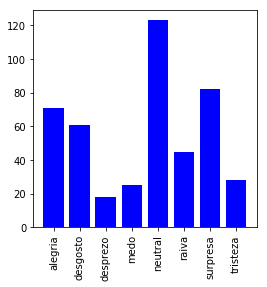

In [11]:
visualiza_distribuicao(imagens)

In [12]:
x, y = np.arange(num_emocoes), qtd_por_emocao(imagens)

Alegria: 71 - Desgosto: 61 - Desprezo: 18 - Medo: 25 - Neutra: 123 - Raiva: 45 - Surpresa: 82 - Tristeza: 28


In [13]:
def pre_processamento_imagens(imagens, img_size=(img_rows,img_cols), dataAugmentation=True):
    """ Esta função é responsável por aplicar transformações
        na imagem. O primeiro parametro aplica transformações 
        de redimensionamento e convete a imagem para escala
        cinza. O segundo aplica transformações de correção
        de brilo e rotação. Este segundo implica no aumento
        do conjunto de dados em 600%

        Args:
            imagens (PIL): lista de tuplas (imagens, emocao).
            dataAugmentation (boolean): flag para aplicar rotações
            na imagem.

        Returns:
            list: retorna uma lista de tuplas (imagem, emocao)
    """
    _imagens =[]
    print('Pre-processamento das imagens...')
    for (imagem, emocao) in imagens:
        # reduz a dimensão da imagem o tamanho 98x98
        imagem = imagem.resize(img_size, Image.ANTIALIAS)
        img_cinza = imagem.convert('L') # escala de cinza.

        # salva o objeto (imagem,emocao)
        _imagens.append((img_cinza, emocao))

        if dataAugmentation: # Aumentando a base de dados
            imagens_rotacionadas = _rotacionar_imagem(img_cinza) # aplicando rotação
            for img in imagens_rotacionadas: # para cada nova imagem 
                _imagens.append((img, emocao)) # salva nova imagem na lista padrão

            imagem_brilho = _corrigir_brilho_imagem(img_cinza) # aplicando brilho
            _imagens.append((imagem_brilho, emocao))
    print('Pre-processamneto das imagens concluido com sucesso!')
    return _imagens

In [14]:
imagens_processadas = pre_processamento_imagens(imagens)

Pre-processamento das imagens...
Pre-processamneto das imagens concluido com sucesso!


In [15]:
# verificando qunatidade de imagens para trabalhar
qtd_imagens = len(imagens_processadas) # get the number of images
print('Quantidade de imagens para trabalhar: ',qtd_imagens)

# iniciando acesso as imagens
# como esta repersentado a imagem = tupla(imagem, categoria)
print('Representação da lista de imagem: ',imagens[0])

Quantidade de imagens para trabalhar:  2718
Representação da lista de imagem:  (<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224 at 0x16FBCF41400>, 0)


Alegria: 426 - Desgosto: 366 - Desprezo: 108 - Medo: 150 - Neutra: 738 - Raiva: 270 - Surpresa: 492 - Tristeza: 168


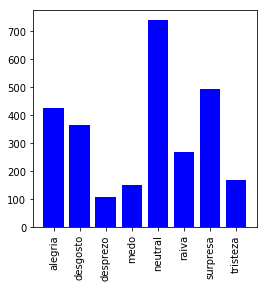

In [16]:
visualiza_distribuicao(imagens_processadas)

In [17]:
x, y2 = np.arange(num_emocoes), qtd_por_emocao(imagens_processadas)

Alegria: 426 - Desgosto: 366 - Desprezo: 108 - Medo: 150 - Neutra: 738 - Raiva: 270 - Surpresa: 492 - Tristeza: 168


In [18]:
diff = np.array(y2) - np.array(y) 
diff

array([355, 305,  90, 125, 615, 225, 410, 140])

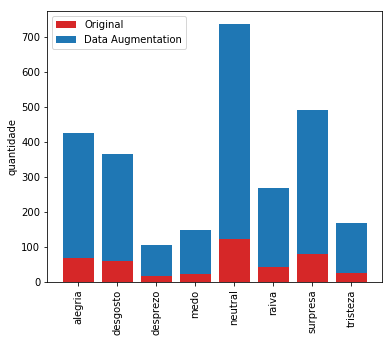

In [19]:
plt.figure(figsize=(6,5))
p1 = plt.bar(x, y, 0.8, color='#d62728')
p2 = plt.bar(x, diff, 0.8,bottom= y)

plt.ylabel('quantidade')
x_label = classes_emocoes
plt.xticks(x, x_label, rotation=90)
plt.legend((p1[0], p2[0]), ('Original', 'Data Augmentation'))

plt.show()


In [20]:
imagens = []
imagens = imagens_processadas
#visualiza_distribuicao(imagens)

<h1>Preparar dados para treinamento</h1><br>
<p>A etapa preparar dados, é responsável por preparar o conjunto de dados para o treinamento, para que seja possível sua utilização pelo framework de aprendizado profundo.</p>

Formato da imagem: (98, 98)
Emocão da imagem: raiva


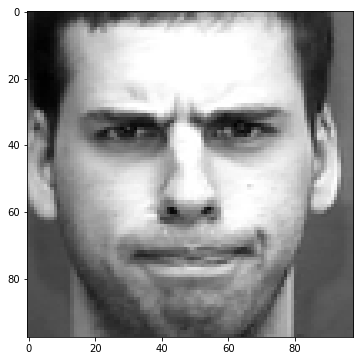

In [22]:
# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, qtd_imagens)
img_aleatoria, emocao_aleatoria = imagens[idx_img_aleatoria][0], imagens[idx_img_aleatoria][1]
#print(img_aleatoria.size)
print("Formato da imagem: {}".format(np.array(img_aleatoria).T.shape))
print("Emocão da imagem: {}".format(classes_emocoes[emocao_aleatoria]))

# Visualizar a imagem aleatoria
plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria, cmap='gray')
#plt.axis('off')

<h3>Extrair dados</h3>

In [23]:
def _get_pixels_imagem(imagem, shape=(img_cols,img_rows)):
    """ Esta função é responsável por extrair os pixels 
        da imagem. Recebe como entrada uma objeto de imagem 
        python e retorna um numpy array contendo uma 
        lista de lista de todos os pixels. Pode ser
        alterado a dimensão da imagem pelo parametro shape.

        Args:
            imagem (PIL): objeto de imagem python.
            shape (tuple): tupla contendo o dimensão
            da imagem de saida.

        Returns:
            array (np.ndarray): retorna um array numpy.
    """
    # cria uma array numpy com uma lista contendo
    # todos os pixels da imagem
    pixel_values = np.array(list(imagem.getdata()))
    
    # redimensiona os pixels para formato 98x98
    pixel_values = pixel_values.reshape(shape)
    return pixel_values

Formato da array de pixels: (98, 98)
Emocão da imagem: raiva


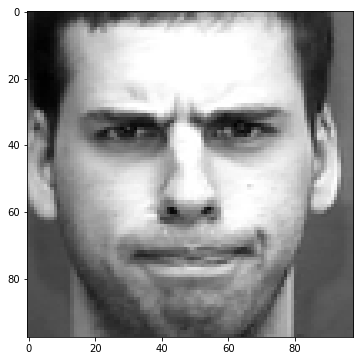

In [24]:
#Conferindo a extração dos pixels e remomtando a imagem

array_pixels = _get_pixels_imagem(img_aleatoria)
print("Formato da array de pixels: {}".format((array_pixels.shape)))
print("Emocão da imagem: {}".format(classes_emocoes[emocao_aleatoria]))

plt.figure(figsize=(6,6))
plt.imshow(array_pixels, cmap='gray')

In [25]:
# extrair os pixels das imagems
def extrair_dados(imagens):
    """ Esta função é responsável por extrair os pixels de 
        todas as imagem da base de dados.
        Recebe como entrada uma lista de objeto de
        imagem python e retorna uma lista de 
        numpy.ndarray contendo todos os pixels
        de todas as imagens.

        Args:
            imagens (list): lista objeto de imagem python.

        Returns:
            array (np.ndarray): retorna uma array numpay.
    """
    data = [] # para armazenar os dados
    array_emocoes = [] # para armazenar os descritores
    
    print("Extraindo os dados...")
    # para cada imagem
    for imagem in range(len(imagens)):
        # extrai o array de pixels da imagem
        data.append(_get_pixels_imagem(imagens[imagem][0]))
        # extrai a emocao que já estava definida na tupla
        array_emocoes.append(imagens[imagem][1])

    print("Quantidade de imagens extraidas:",len(data))
    print("Quantidade de emocoes extraidas:",len(array_emocoes))
    print("Extração de pixels completa!")
    return data, array_emocoes

In [26]:
# empilhar dados para trabalhar com o framework
data, array_emocoes = extrair_dados(imagens)

Extraindo os dados...
Quantidade de imagens extraidas: 2718
Quantidade de emocoes extraidas: 2718
Extração de pixels completa!


<h3>Empilhar dados</h3>

In [27]:
# Função que empilha o conjunto de dados,
# em formato de tupla para trabalhar com o deep learning
def empilhar_dados(dados):
    """ Esta função é responsável por empilhar os dados 
        para o formato que exigido para trabalho com o 
        framework Keras. Recebe como entrada lista de 
        dados e retorna uma tupla contendo a 
        quantidade de dados, dimensão x, e dimensão y.

        Args:
            dados (list): lista de dados.

        Returns:
            tuple: retorna uma tupla com 
            (quantidade, largura, altura).
    """
    print("Empilhando conjunto de dados:(quantidade, largura, altura)...")
    # faz uso da fucionalidade numpy de empilhamento
    dados_empilhados = np.stack(dados) 
    print("novo formato dos dados:", dados_empilhados.shape)
    return dados_empilhados

In [28]:
# empilhar imagens
print('Empilhando imagens...')
data = empilhar_dados(data)

print('Empilhando descritores de emoção...')
# empilhar descritores de emoção
labels = empilhar_dados(array_emocoes)

print("Fase de empilhamento completa!")

Empilhando imagens...
Empilhando conjunto de dados:(quantidade, largura, altura)...
novo formato dos dados: (2718, 98, 98)
Empilhando descritores de emoção...
Empilhando conjunto de dados:(quantidade, largura, altura)...
novo formato dos dados: (2718,)
Fase de empilhamento completa!


In [29]:
# Conferindo os pixels da imagem a partir dos dados estraidos.
print("Formato dos dados: {}".format(data[0].shape))
display(pd.DataFrame(data[0]))

Formato dos dados: (98, 98)


0    1    2    3    4    5    6    7    8    9  ...    88   89   90   91  \
0   255  254  255  251  160   76   36   22   16   14 ...    43  141  225  246   
1   255  254  255  198   95   43   24   21   14   13 ...    18   79  172  242   
2   255  254  239  142   60   26   22   18   13   13 ...    13   39  126  220   
3   254  255  212  101   39   26   21   12   12   18 ...    12   22   95  170   
4   255  252  170   69   32   26   17   11   15   21 ...     8   14   43  126   
5   255  228  114   41   28   22   14   14   15   21 ...     7   11   33   95   
6   255  175   70   32   25   18   14   10   16   23 ...     4    7   20   64   
7   218  112   41   26   24   16    9   13   19   17 ...     2    6   12   39   
8   145   68   39   16   10    7    8   18   22   18 ...     2    4   10   20   
9   120   67   19   14    7    3    7   22   22   11 ...     1    2    5    8   
10  123   54    9   13    8    6   12   23   20   12 ...     1    0    1    6   
11  115   34   14   14    5    6   20   24   14   11 ...     0    0    0    2   
12   94   23   14   11    3    9   22   23   15    9 ...     0    0    0    0   
13   76   21   11    6    0   12   21   14    9    8 ...     0    0    0    1   
14   51   18   16    7    2   14   18   13   11   11 ...     0    0    0    0   
15   45   16   13    4    8   22   21   17   14   12 ...     2    1    1    0   
16   42   14    7    4   17   24   22   14   12   14 ...     2    1    1    1   
17   37   13    6    6   21   20   18   13   11   16 ...     0    0    0    1   
18   33   11    3    9   23   21   15   10   12   14 ...     0    0    0    0   
19   46    7    0   10   22   19   13   10   15   17 ...     0    0    0    0   
20   36    9    6   15   20   16   12   11   13   15 ...     1    0    0    0   
21   35   10   10   12   15   13   12    9   12   13 ...     1    0    0    0   
22   37   16   12   15   19   16   14   16   14   12 ...     2    0    0    0   
23   34   15   13   15   17   15   14   15   16   15 ...     2    0    0    0   
24   45   18   12   14   15   13   12   14   14   12 ...     2    0    0    0   
25   50   21   12   15   19   14   13   13   10   13 ...     6    0    0    0   
26   51   22   11   10   14   11   13   14   11   13 ...     9    1    0    0   
27   69   31   14   15   19   17   14   13   13   14 ...     9    2    0    0   
28   82   47   23   12   13   11   14   13   11   11 ...     9    3    0    0   
29  112   81   41    3   15   15   15   13   11   13 ...     7    8    3    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ... ...   ...  ...  ...  ...   
68   31   22   19   23   25   27   28   27   25   21 ...    20   26   35   38   
69   28   35   36   35   35   35   34   31   26   21 ...     9   16   23   30   
70   36   22   21   23   27   31   32   28   23   21 ...     9   11   17   20   
71   80   34   26   24   22   24   25   24   22   20 ...     5   10   15   22   
72   82   42   30   29   28   27   26   25   24   22 ...     1    3    8   10   
73   73   44   34   35   37   33   29   26   22   19 ...     4    6    4    2   
74  117   83   53   45   42   35   29   26   24   20 ...     3    2    0    2   
75  147  141  117   78   44   34   30   26   23   19 ...     1    1    1    1   
76   96   86   79   70   49   39   34   28   23   19 ...     1    3    2    1   
77  146  129  117   88   62   51   41   34   27   22 ...     0    0    1    1   
78   51   55   71   77   61   50   38   29   25   23 ...     0    0    1    3   
79  136  109   80   68   51   40   30   31   32   29 ...     3    3    4    4   
80  179  154  122   97   84   88  106  145  168  170 ...     0    0   17   65   
81  198  193  186  186  189  193  191  190  194  195 ...    68   94  107  135   
82  206  201  197  197  197  197  188  184  191  197 ...   177  180  168  160   
83  218  217  213  207  197  193  195  201  203  211 ...   160  162  160  160   
84  216  212  210  207  208  213  213  213  215  220 ...   163  163  165  163   
85  217  217  219  221  220  219  21

In [36]:
# Visualizando uma imagem a partir dos dados extraidos
# Seleciona um indice
idx_img_aleatoria = random.randint(0, data.shape[0])
print("Indice da imagem: ", idx_img_aleatoria)

# seleciona uma imagem
img_aleatoria = data[idx_img_aleatoria]
print("Formato do imagem: {}".format(img_aleatoria.shape))
print("Emocão da imagem: {}".format(classes_emocoes[labels[idx_img_aleatoria]]))

plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria, cmap='gray')

Indice da imagem:  556
Formato do imagem: (98, 98)
Emocão da imagem: desgosto


In [37]:
# organizando dados para trabalhar com o keras
(X, y) = (data, labels)

In [38]:
# backup para plot na predição
print('Criando backup dos dados...')
X_test_orig = X
Y_test_orig = y
print('Backup - Estrutura do dados: ',X_test_orig.shape)
print('Backup - labels: ',len(Y_test_orig))
print('Backup completo!')

Criando backup dos dados...
Backup - Estrutura do dados:  (2718, 98, 98)
Backup - labels:  2718
Backup completo!


In [39]:
def amostragem(quantidade, limite):
    fig = plt.figure(figsize=(16,16))
    for i in range(quantidade):
        idx = random.randint(0,limite-1),
        input_img = X_test_orig[idx[0]].reshape(img_cols, img_rows)
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img, interpolation='nearest', cmap='gray')
        idx_emocao = idx[0]
        plt.text(0, 0, classes_emocoes[Y_test_orig[idx_emocao]], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

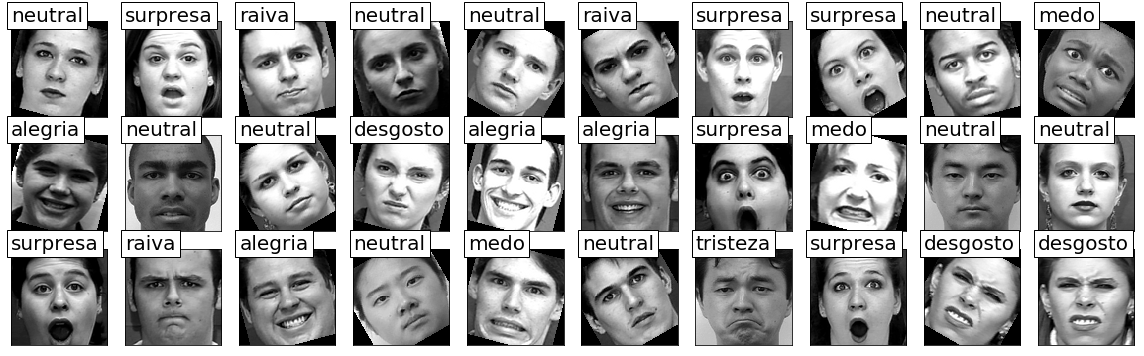

In [40]:
# Visualizando amostra dos dados
amostra = 30
amostragem(amostra, len(X_test_orig))

<h3>Separar dados</h3>

In [41]:
# Separando os dados para treinamento
def separar_treino_e_teste(imagens, descritores):
    """ Esta função é responsável por separa os dados 
        em conjunto de treino e teste. Recebe como 
        entrada tupla contendo todos os dados da 
        imagens e uma tupla contendo os descritores. 
        Retorna uma tupla contendo imagens de treino,
        descritores de treino, imagens de teste e 
        descritores de teste.

        Args:
            imagens (tuple): tupla de dados .

        Returns:
            tuple: tupla contendo dados de treino, dados de teste. 
    """
    # test_size=0.2 = percentual de separação 20% para teste
    # random_state = definindo a semente para escolha aleatoria
    print('Separando os dados em grupo de treino e teste...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, random_state= int(qtd_imagens))
    print('Imagens separadas para treino: ',X_train.shape)
    print('Imagens separadas para teste: ',X_test.shape)
    print('Emoções separadas para treino: ',y_train.shape)
    print('Emoções separadas para teste: ',y_test.shape)
    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = separar_treino_e_teste(X, y)

Separando os dados em grupo de treino e teste...
Imagens separadas para treino:  (2174, 98, 98)
Imagens separadas para teste:  (544, 98, 98)
Emoções separadas para treino:  (2174,)
Emoções separadas para teste:  (544,)


<h3>Formatar dados</h3>

In [43]:
# configura shape, adicionando a camanda de cor
# Shape é configurado de acordo com framework de background: tensorflow(tf) ou Theano(th)
def formatar_shape(X_train, X_test, canais=1):
    """ Esta função é responsável por formatar os dados
        para trabalhar com o deep learning, de acordo com
        o framework que está em background (tensorflow(tf) 
        ou Theano(th)).
        Recebe como parametro a quantidade de canais de cor
        que as imagens possuem.
        
        Args:
            X_train (tuple): imagens de treinamento
            X_train (tuple): imagens de teste
            canais (int): quantidade de canais de profundidade.
        Returns:
            tuple: tupla contendo dados de treino, dados de teste,
            e o shape dos dados, formatados para deep learning. 
    """
    print("Adicionando canais de cores na estrutura de dados...")
    # O framework theano trabalha com a quantidade de canais 
    # de cores a frente da dimesão da imagem
    if K.image_data_format() == 'channels_first': # = th
        shape = (canais, img_cols, img_rows)
        #shape = (1, img_cols, img_rows)
        print("Trabalhando com theano:", shape)
    # O framework tensorflow trabalha com a quantidade de canais
    # de cores apos a dimesão da imagem
    else:  # channel_last = tf
        shape = (img_cols, img_rows, canais)
        #shape = (img_cols, img_rows, 1)
        print("Trabalhando com tensorflow:",shape)
    print("Novo formato para estrutura de dados contendo o canal de cor: ",shape)
    print('Alterando o formato das imagens, colocando a estrutura com canal de cor...')
    X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
    X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')
    print('Novo formato das imagens separadas para treino: ',X_train.shape)
    print('Novo formato das imagens separadas para teste: ',X_test.shape)
    # cada pixels é normalizado = pixel = pixel / 255
    print('Normalizando os dados...')
    X_train /= 255
    X_test /= 255
    return X_train, X_test, shape

In [44]:
X_train, X_test, shape = formatar_shape(X_train, X_test)

Adicionando canais de cores na estrutura de dados...
Trabalhando com tensorflow: (98, 98, 1)
Novo formato para estrutura de dados contendo o canal de cor:  (98, 98, 1)
Alterando o formato das imagens, colocando a estrutura com canal de cor...
Novo formato das imagens separadas para treino:  (2174, 98, 98, 1)
Novo formato das imagens separadas para teste:  (544, 98, 98, 1)
Normalizando os dados...


In [45]:
# Definindo a qunatidade de neurõnios por camada da DNN

# quantidade de pixels na camada de entrada de dados
# um neuronio para cada pixel
num_pixels = X_train.shape[1] * X_train.shape[2]
print("Quantidade de neurônios (camada entrada): ",num_pixels)

Quantidade de neurônios (camada entrada):  9604


<h3>Criar matriz one-hot</h3>

In [46]:
# Criando a classificação
# Converte um vetor de classe (inteiros) em matriz de classe verdade (binária).
def criar_matriz_verdade(y_train, y_test):
    """ Esta função é responsável por criar uma matriz
        verdade para todos os descritores do conjunto de dados.
        Recebe como parametro os descritores de treino e teste.
        
        Args:
            Y_train (tuple): descritores de emoção de treinamento
            Y_test (tuple): descritores de emoção de teste 
        
        Returns:
            tuple: tupla contendo as matrizes verdade dos
            descritores de treino, dados de teste,
    """
    print('Criando a matriz de classificação binária...')
    # Classificando os descritores de treino
    Y_train = np_utils.to_categorical(y_train)
    # Classificando os descritores de teste
    Y_test = np_utils.to_categorical(y_test)

    # verificando a quantidade de classes encontradas
    n_treino = Y_train.shape[1]
    print('Classes encontradas para imagens: ', n_treino)

    # verificando a quantidade de classes encontradas
    n__teste = Y_test.shape[1]
    print('Classes encontradas para emocoes: ', n__teste)
    return Y_train, Y_test

In [47]:
Y_train, Y_test = criar_matriz_verdade(y_train, y_test)

Criando a matriz de classificação binária...
Classes encontradas para imagens:  8
Classes encontradas para emocoes:  8


In [48]:
# visualizando matriz verdade
print(Y_train[:5])
print(Y_train.shape)
print(Y_test[:5])
print(Y_test.shape)

[[ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]]
(2174, 8)
[[ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]]
(544, 8)


<h1>Criar rede neural profunda</h1>
<p>Nesta etapa do desenvolvimento é criado a arquitetura da rede neural utilizando as técnicas de aprendizado profundo.
Para este trabalho, será utilizado o modelo de redes neurais convolucionais.
A rede neural profunda, utilizada neste protótipo, foi definida após inúmeras tentativas descritas na seção de experimentos, e possui a arquitetura ilustrada na figura abaixo.</p>

In [72]:
display(HTML('''<img src="./util/Diagrama - Arquitetura da rede neural -FINAL.png">'''))

In [52]:
# Criando arquitetura da rede DNN
def criar_deep_cnn_10(num_classes, shape):
    """ Esta função é responsável por criar a rede neural convulocional.
        Recebe como parametro a quantidade de categorias a serem
        classificadas pela rede, e o formato de entrada dos dados.

        Args:
            num_classes (int): quantidade de categorias a serem classificadas
            shape (tuple): formato de entrada dos dados.
            
        Returns:
            model: rede neural profunda completa.
    """
    nucleos_conv1 = 64  # Quantidade de núcleos (Campos receptivos locais)
    nucleos_conv2 = 128 # Quantidade de núcleos (Campos receptivos locais)
    nucleos_conv3 = 256 # Quantidade de núcleos (Campos receptivos locais)
    dropout_1 = 0.25    # Dropout para emitar overffiting = 25%
    dropout_2 = 0.5     # Dropout para emitar overffiting = 50%
    neuronios_camada_densa = 512 # quantidade de neuronios escondidos para a camada densa
    campos_receptivos_nucleos = (5, 5) # tamanho do nucleo de convolucao
    campos_receptivos_pooling = (2, 2) # tamanho do nucleo de pooling

    # tipo keras senquencial (https://keras.io/getting-started/sequential-model-guide/)
    model = Sequential()
    
    # [INICIO - Primeira bloco de convolução]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade) para entrada de dados. 
    # Camada ConvNet terá 64 núcleos (campos receptivos de 5 x 5 pixels).
    # Padding = same, o tamanho da saída será igual ao tamanho da entrada: input=(98,98) -> output=(98,98)
    # Por default a rede CONV2D já utiliza bias=True e os inicializa com 0
    # Por default o tamanho do passo é 1 pixel, stride=(1,1)
    model.add(Conv2D(nucleos_conv1, campos_receptivos_nucleos, input_shape=shape, padding='same', name='Bl01_Conv'))
    # Adicionado uma camada para função de ativação do neurônio, função PRelu (https://arxiv.org/abs/1502.01852)  
    model.add(PReLU(name='Bl01_PReLU'))
    # Adicionando uma camada de subamostragem (AveragePooling2D).
    # Esta camada reduz pela metade as dimensões da imagem, ou seja, input=(98,98) -> output=(49, 49)
    model.add(AveragePooling2D(pool_size=(campos_receptivos_pooling), name='Bl01_Pooling'))
    # [FIM - Primeiro bloco convolucional]
    
    # [INICIO - Segundo bloco convolucional]
    # Camada ConvNet terá 128 núcleos (campos receptivos de 5 x 5 pixels).
    # Arranjo espacial com apenas 1 canal de cor e imagem com dimesão (49, 49)
    # Padding = valid, o tamanho da saída será menor ao tamanho da entrada: input=(49, 49) -> output=(45, 45)=(Size-nucleo+1)
    model.add(Conv2D(nucleos_conv2, campos_receptivos_nucleos, name='Bl02_Conv'))
    # Adicionado uma camada para função de ativação do neurônio, função PRelu (https://arxiv.org/abs/1502.01852)
    model.add(PReLU(name='Bl02_PRelu'))
    # Adicionando uma camada de subamostragem (AveragePooling2D).
    # Esta camada reduz pela metade as dimensões da imagem, ou seja, input=(45,45) -> output=(22, 22)
    model.add(AveragePooling2D(pool_size=campos_receptivos_pooling,  name='Bl02_Pooling'))
    # [FIM - Segundo bloco convolucional]
    
    # [INICIO - Terceiro bloco convolucional]
    # Camada ConvNet terá 256 núcleos (campos receptivos de 5 x 5 pixels).
    # Padding = valid, o tamanho da saída será menor ao tamanho da entrada: input=(22, 22)  -> output=(18, 18)=(Size-nucleo+1)
    # Esta camada reduz pela metade as dimensões da imagem, ou seja, input=(18, 18) -> output=(9, 9) 
    model.add(Conv2D(nucleos_conv3, campos_receptivos_nucleos,  name='Bl03_Conv'))
    # Adicionado uma camada para função de ativação do neurônio, função PRelu (https://arxiv.org/abs/1502.01852) 
    model.add(PReLU(name='Bl03_PRelu'))
    # Adicionando uma camada de subamostragem (AveragePooling2D).
    model.add(AveragePooling2D(pool_size=campos_receptivos_pooling, name='Bl03_Pooling'))
    # [FIM - Terceiro bloco convolucional]
    
    # [INICIO - Interligação da rede convolucional para rede totalmente conectada]
    # adiciona uma camada de dropout, para evitar overfitting
    # Não altera as dimensões da imagem
    model.add(Dropout(dropout_1, name='Dropout1'))
    # Achata o vetor
    # Não altera as dimensões da imagem
    # Tranforma uma imagem de input=(9, 9) e com 256 núcleos, em um vetor de 20.736 posições=(9*9*256)
    model.add(Flatten(name='Ligacao'))
    # [FIM - Interligação de rede convolucional para rede totalmente conectada]
    
    # [INICIO - Primeiro bloco de rede totalmente conectada]
    # Adicionando primeira camada densa (totalmente conectada), destinada a classificação.
    # Possui input=(20.736) e saída de 512 neurônios.
    # Não altera as dimensões da imagem
    model.add(Dense(neuronios_camada_densa, name='Classi_Densa1'))
    # Adicionado uma camada para função de ativação do neurônio, função PRelu (https://arxiv.org/abs/1502.01852)  
    model.add(PReLU(name='Classi_PRelu'))
    # [FIM - primeiro bloco de rede totalmente conectada]
    
    # [INICIO - Interligação dos blocos de rede totalmente conectados]
    # adiciona uma camada de dropout, para evitar overfitting
    # Não altera as dimensões da imagem
    model.add(Dropout(dropout_2, name='Dropout2'))
    # [FIM - Interligação dos blocos de rede totalmente conectados]
    
    # [INICIO - Segundo bloco de rede totalmente conectada]
    # Adicionando segunda camada densa (totalmente conectada) para saída de dados
    # Possui input=(512) e saída de 8 neurônios.
    # Os 8 neurônios são a classificação para as 8 emoções
    # Função de ativação do neurônio será Softmax (https://en.wikipedia.org/wiki/Softmax_function)
    model.add(Dense(num_classes, activation='softmax',name='Classi_Densa2'))
    
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy']) = #time: 2h 9min 4s=83.85%
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy']) = 2h 1min 50s=81.65%
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) = time: 2h 4min 50s=27.89%
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'adagrad', metrics = ['accuracy']) =time: 2h 5min 25s= 35.96%
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy']) = 
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy']) = 
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy']) 

    #Prelu = 2h 27min 59s + 2h 25min 39s + 2h 25min 49s + 2h 33min 18s + 7h 16min 59s= 86.42%

    # Função para otimização estocástica, requer apenas gradientes de primeira ordem com pouco requisito de memória.
    # Referência: (KINGMA, Diederik; BA, Jimmy. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.)
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
    adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [53]:
# Compilando o modelo proposto
model = criar_deep_cnn_10(num_emocoes, shape)

In [54]:
# visualizando o modelo criado
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bl01_Conv (Conv2D)           (None, 98, 98, 64)        1664      
_________________________________________________________________
Bl01_PReLU (PReLU)           (None, 98, 98, 64)        614656    
_________________________________________________________________
Bl01_Pooling (AveragePooling (None, 49, 49, 64)        0         
_________________________________________________________________
Bl02_Conv (Conv2D)           (None, 45, 45, 128)       204928    
_________________________________________________________________
Bl02_PRelu (PReLU)           (None, 45, 45, 128)       259200    
_________________________________________________________________
Bl02_Pooling (AveragePooling (None, 22, 22, 128)       0         
_________________________________________________________________
Bl03_Conv (Conv2D)           (None, 18, 18, 256)       819456    
__________

In [55]:
# Verificando o arranjo espacial do modelo
for i, layer in enumerate(model.layers):
        print ("Camada", i, "\t", layer.name.strip(),"\t\t", layer.input_shape, "\t", layer.output_shape)

Camada 0 	 Bl01_Conv 		 (None, 98, 98, 1) 	 (None, 98, 98, 64)
Camada 1 	 Bl01_PReLU 		 (None, 98, 98, 64) 	 (None, 98, 98, 64)
Camada 2 	 Bl01_Pooling 		 (None, 98, 98, 64) 	 (None, 49, 49, 64)
Camada 3 	 Bl02_Conv 		 (None, 49, 49, 64) 	 (None, 45, 45, 128)
Camada 4 	 Bl02_PRelu 		 (None, 45, 45, 128) 	 (None, 45, 45, 128)
Camada 5 	 Bl02_Pooling 		 (None, 45, 45, 128) 	 (None, 22, 22, 128)
Camada 6 	 Bl03_Conv 		 (None, 22, 22, 128) 	 (None, 18, 18, 256)
Camada 7 	 Bl03_PRelu 		 (None, 18, 18, 256) 	 (None, 18, 18, 256)
Camada 8 	 Bl03_Pooling 		 (None, 18, 18, 256) 	 (None, 9, 9, 256)
Camada 9 	 Dropout1 		 (None, 9, 9, 256) 	 (None, 9, 9, 256)
Camada 10 	 Ligacao 		 (None, 9, 9, 256) 	 (None, 20736)
Camada 11 	 Classi_Densa1 		 (None, 20736) 	 (None, 512)
Camada 12 	 Classi_PRelu 		 (None, 512) 	 (None, 512)
Camada 13 	 Dropout2 		 (None, 512) 	 (None, 512)
Camada 14 	 Classi_Densa2 		 (None, 512) 	 (None, 8)


<h1>Treinamento da rede neural profunda</h1>
<p>Nesta seção é apresentado a etapa de treinamento da rede neural profunda.
Cada imagem do conjunto de dados de treino é convoluída através da rede neutral profunda. 
É realizado a extração das características em cada bloco de convolução e atualizado os pesos do treinamento.</p>

In [56]:
# monitor para ouvir e parar o treinamento caso o aprendizado comece a cair
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')

In [57]:
# chekpoint para salvar o mehlor aprendizado enter as epocas
filepath="pesos_teste_10-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,  # caminho para o modelo salvo
                             monitor= 'val_acc', # qual parametro vai acompanhar
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # sobreescreve o modelo apenas se for o melhor
                             mode='auto') # dependecia de acorco com o monitor

#callback_list=[monitor, checkpoint]
callback_list=[checkpoint]

In [53]:
def treinar_rede_deep_cnn(model, X_train, Y_train, 
                          X_test, Y_test, epocas=20, batch=99, callback_list = None):
    """ Esta função é responsável por realizar o treinamento
        da rede neural convolucional profunda.
        Recebe como parâmetro o modelo da rede, a quantidade de 
        epocas de treinamento, e o tamanho do lote de treinamento.

        Args:
            model (sequencial): modelo da rede neural
            X_train (array): imagens de treino.
            Y_train (array): descritores de treino.
            X_teste (array): imagens de teste.
            Y_teste (array): descritores de teste.
            epocas (int): quantidade de epocas de treinamento
            batch (int): tamanho do lote de treinamento.
            
        Returns:
            history: log's do aprendizado da rede
            model: rede neural profunda completa.
    """
    print('Treinando a rede neural profunda...')
    # % time: contador do tempo de processamento
    %time history = model.fit(X_train,Y_train,validation_data=(X_test, Y_test), callbacks=callback_list, epochs= epocas,batch_size= batch,verbose=1)
    print('Treinanmeto finalizado!')
    return history, model

In [ ]:
history, model = treinar_rede_deep_cnn(model, X_train, Y_train, X_test, Y_test, epocas=20, batch=99, callback_list)

In [ ]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, Y_test, verbose=1)
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

<h3>Gráfico do aprendizado da rede</h3>
<p>Este gráfico ilustra a precisão do treinamento e do teste, assim como
a taxa de erro, para cada interação realizada pela rede.</p>

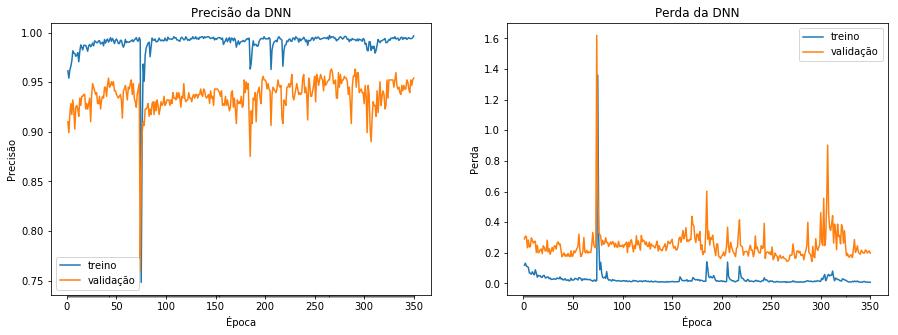

In [49]:
def plot_model(history):

    # Cria subplots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Precisão
    axs[0].plot(range(1,len(history.history['acc'])+1),history.history['acc'])
    axs[0].plot(range(1,len(history.history['val_acc'])+1),history.history['val_acc'])
    axs[0].set_title('Precisão da DNN')
    axs[0].set_ylabel('Precisão')
    axs[0].set_xlabel('Época')
    axs[0].set_xticks(np.arange(1,len(history.history['acc'])+1),len(history.history['acc'])/10)
    axs[0].legend(['treino', 'validação'], loc='best')
    
    # Perda
    axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
    axs[1].set_title('Perda da DNN')
    axs[1].set_ylabel('Perda')
    axs[1].set_xlabel('Época')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['treino', 'validação'], loc='best')
    
    # Visualizar
    plt.show()
        
plot_model(history)

<h3>Salvando a arquiterura criada</h3>
<p>Esta etapa salva a arquitetura criada para uso posterior.
É salvo no formato .json</p>

In [72]:
# Salvando o modelo criado
print('Salvando o modelo...')
# serialize model para formato JSON
MODELO_SALVO_JSON = 'deep_emotive_model_t10_faces.json'
model_json = model.to_json()
with open(MODELO_SALVO_JSON, "w") as json_file:
    json_file.write(model_json)
    print('Modelo salvo com sucesso!')


Salvando o modelo...
Modelo salvo com sucesso!


In [57]:
# Treinando o modelo DNN para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino

PESOS_SALVOS = 'pesos_teste_10-265-0.96.1.hdf5'

# Flag True ou false para retreinar a rede
if True and os.path.exists(PESOS_SALVOS):    
    print('Carregando pesos salvos de treino anterior...')
    model.load_weights(PESOS_SALVOS)
    print('Pesos carregados com sucesso!')
else:
    # treinando a DNN para 20 épocas
    #callback_list=[monitor,checkpoint]
    callback_list=[checkpoint]
    print('Treinando a DNN...')
    %time history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=callback_list, epochs=350, batch_size=99, verbose=1)
    print('Treinanmeto finalizado!')

Carregando pesos salvos de treino anterior...
Pesos carregados com sucesso!


<h3>Carregando o modelo salvo</h3>

In [58]:
# Carregando o modelo salvo
# Lendo o modelo salvo em arquivo para um novo modelo
MODELO_SALVO_JSON = 'deep_emotive_model_t10_faces.json'

print("Carregando o modelo...")
json_file = open(MODELO_SALVO_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print('Modelo carregado com sucesso!')

Carregando o modelo...
Modelo carregado com sucesso!


In [62]:
# Carregando o melhor pesos do checkout para para o novo modelo
MELHOR_PESO = './pesos/pesos_teste_10-266-0.96.3.hdf5'

print("Carregando os melhores pesos...")
loaded_model.load_weights(MELHOR_PESO)

# Compilando o modelo que estava salvo
# lr: taxa de aprendizado
# decay: tamanho do passo da caída do gradiente
adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

# Copilando o modelo
# Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
# métrica de reconhecimento será precisão.
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print("Carregamento dos melhores pesos completo!")

Carregando os melhores pesos...
Carregamento dos melhores pesos completo!


In [63]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bl01_Conv (Conv2D)           (None, 98, 98, 64)        1664      
_________________________________________________________________
Bl01_PReLU (PReLU)           (None, 98, 98, 64)        614656    
_________________________________________________________________
Bl01_Pooling (AveragePooling (None, 49, 49, 64)        0         
_________________________________________________________________
Bl02_Conv (Conv2D)           (None, 45, 45, 128)       204928    
_________________________________________________________________
Bl02_PRelu (PReLU)           (None, 45, 45, 128)       259200    
_________________________________________________________________
Bl02_Pooling (AveragePooling (None, 22, 22, 128)       0         
_________________________________________________________________
Bl03_Conv (Conv2D)           (None, 18, 18, 256)       819456    
__________

<h3>Verificando a precisão do modelo salvo</h3>

In [64]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(loaded_model.metrics_names))
metricas = loaded_model.evaluate(X_test, Y_test, verbose=1)
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
544/544 [==============================] - 28s    
Erro de: 1.29%
Precisão de: 98.71%


<h1>Predição</h1>
<p>A predição é a etapa final do processamento de execução do protótipo, e é responsável por apresentar a classificação de uma ou mais imagens, baseado no aprendizado adquirido pela rede, na fase de treinamento</p>

In [65]:
def predizer(model, imagens):
    """Esta função é responsável por realizar a predição 
       do conjunto de dados. Recebe como parametro o 
       modelo da rede, e retorna uma tupla contendo a 
       matriz de probabilidade e a matriz da classificação.

       Args:
           model (sequencial): modelo da rede neural
           treinado.
           imagens (list): lista contendo as imagens
           para predizer a emoção
       Returns:
           np.array: matriz de probabilidade
           np.array: matriz da classificação
    """
    print('Predição da(s) imagem(ns)...')
    m_probabilidade = model.predict(X_test, batch_size=32, verbose=1)
    m_predicao = [np.argmax(prob) for prob in m_probabilidade]
    
    print('Predição completa!')
    print('Quantidade de imagens analisadas: ', len(m_predicao))
    return m_probabilidade, m_predicao

In [66]:
y_probabilidade, predicted = predizer(loaded_model, X_test)

Predição da(s) imagem(ns)...
544/544 [==============================] - 27s    
Predição completa!
Quantidade de imagens analisadas:  544


In [67]:
# Verificando a precisão por classe
# precision= A precisão é a razão onde é o número de positivos verdadeiros e o número de falsos positivos
# recall= O recall é a razão onde é o número de positivos verdadeiros e o número de falsos negativos
# f1-score= A média harmônica ponderada da precisão e recall
# support= O suporte é o número de ocorrências de cada classe verdade

print(classification_report(np.argmax(Y_test, axis=1), predicted, target_names=classes_emocoes))

             precision    recall  f1-score   support

    alegria       1.00      1.00      1.00        98
   desgosto       1.00      0.94      0.97        68
   desprezo       1.00      0.96      0.98        23
       medo       0.97      1.00      0.99        34
    neutral       0.98      0.99      0.99       136
      raiva       0.95      0.98      0.96        54
   surpresa       1.00      1.00      1.00       107
   tristeza       1.00      1.00      1.00        24

avg / total       0.99      0.99      0.99       544



<h3>Amostras da predição</h3>
<p>Nesta etapa é ilustrado algumas imagens que foram preditas pela rede Deep-Emotive.<br>
São selecionadas trinta imagens aleatórias e preditas, o resultado é plotado.</p>

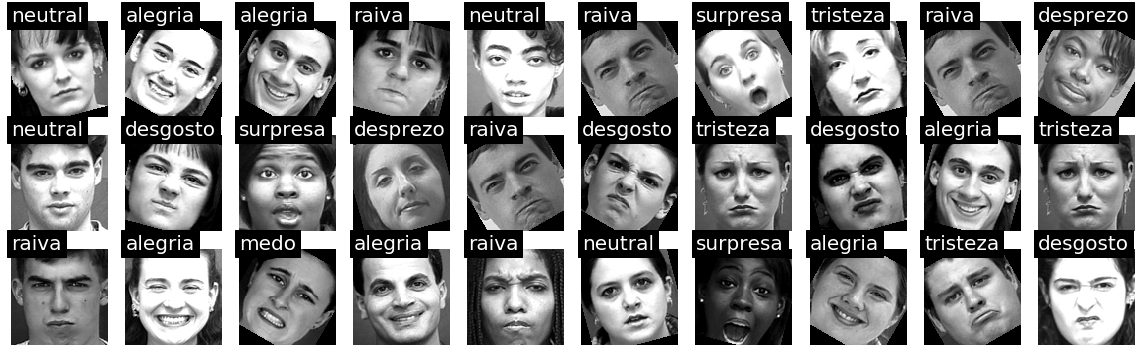

In [68]:
amosta = 30
fig = plt.figure(figsize=(16,16))
for i in range(amosta):
    #plt.subplot(1, amosta, i+1)
    # Seleciona uma imagem aleatoria
    idx_img_aleatoria = random.randint(0, len(X_test[0]))
    img_aleatoria = X_test[idx_img_aleatoria]
    
    ax = fig.add_subplot(10,10,i+1)
    # Visualiza a imagem escolhida aleatoriamente
    plt.imshow(img_aleatoria.reshape(img_cols, img_rows), interpolation='nearest', cmap='gray')

    # Visualiza o label
    plt.text(0, 0, classes_emocoes[predicted[idx_img_aleatoria]], color='white', 
             bbox=dict(facecolor='black', alpha=1), fontsize=20)
        
    plt.axis('off')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

<h3>Matriz de confusão</h3>

In [69]:
# Função para matriz de confusão da predição

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Base de teste')
    plt.xlabel('Predições')

Verificando quantidade de imagens da predição: 544
Verificando formato dos dados de testes: (544, 8)


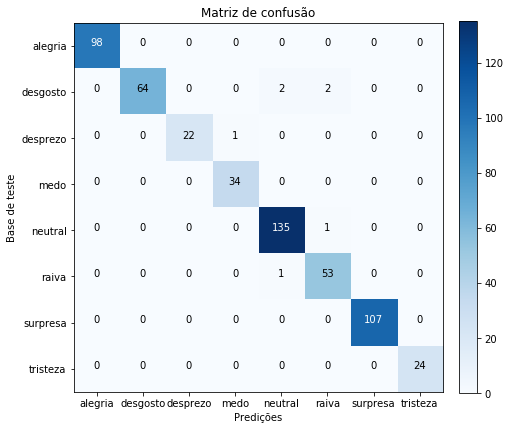

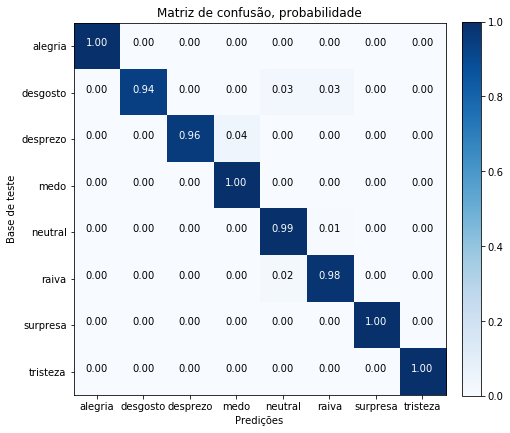

In [70]:
# Visualizando matriz de confusão da predição
#classes = ['alegria', 'desgosto', 'desprezo', 'medo', 'neutral', 'raiva', 'surpresa', 'tristeza']
# Precisa ter o mesmo formato
print('Verificando quantidade de imagens da predição: {}'.format(len(predicted)))
print('Verificando formato dos dados de testes: {}'.format(Y_test.shape))


cnf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), predicted)
np.set_printoptions(precision=2)

# Visualizando a matriz de confusão sem normalização.
# mosta a quantidade de imagens classificadas para cada label
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes_emocoes,
                      title='Matriz de confusão')

# Visualizando a matriz de confusão com normalização.
# mosta a precisão para cada label classificado
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes_emocoes, normalize=True,
                      title='Matriz de confusão, probabilidade')

plt.show()

Alegria: 426 - Desgosto: 366 - Desprezo: 108 - Medo: 150 - Neutra: 738 - Raiva: 270 - Surpresa: 492 - Tristeza: 168


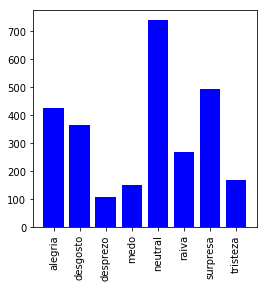

In [71]:
# Conferindo a distribuição novamente
# Verificando se a quantidade de amostra pode influenciar no aprendizado
visualiza_distribuicao(imagens)

<h1>Visualização dos núcleos</h1>
<p>Visualização das camadas intermediárias, que consiste em visualizar como os neurônios de cada mapa de característica estão sendo ativados. Isto é realizado através da visualização da saída de cada camada convolucional da rede neural profunda.</p>

In [73]:
# Listando as camadas da rede DNN

lista_camadas = OrderedDict()
for layer in model.layers[0:]:
    lista_camadas[layer.name] = layer
    print(layer.name)

Bl01_Conv
Bl01_PReLU
Bl01_Pooling
Bl02_Conv
Bl02_PRelu
Bl02_Pooling
Bl03_Conv
Bl03_PRelu
Bl03_Pooling
Dropout1
Ligacao
Classi_Densa1
Classi_PRelu
Dropout2
Classi_Densa2


In [74]:
def get_ativacoes(model, camada, input_img_data):
    # Função tesorflow
    ativacoes_out = K.function([model.layers[0].input, K.learning_phase()], [camada.output,])
    # Pega as ativações da imagem
    ativacoes = ativacoes_out((input_img_data, False))
    return ativacoes

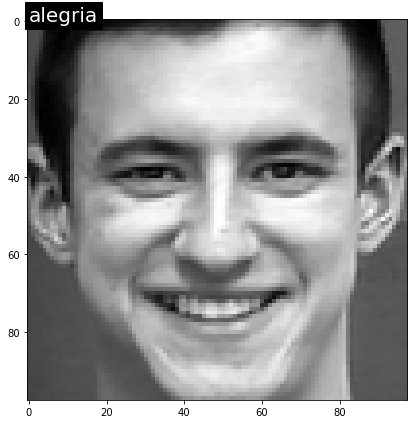

In [116]:
# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, X_test.shape[0])

input_img_data = X_test[idx_img_aleatoria].reshape(img_rows, img_cols)
plt.figure(figsize=(7,7))
plt.imshow(input_img_data, cmap="gray")
# Visualiza o label
plt.text(0, 0, classes_emocoes[predicted[idx_img_aleatoria]], color='white', 
         bbox=dict(facecolor='black', alpha=1), fontsize=20)
#plt.axis('off')

In [117]:
# Conferindo o shape
input_img_data = np.expand_dims(input_img_data, axis=0)
print('Input image shape:', input_img_data.shape)

Input image shape: (1, 98, 98)


In [118]:
# Formantado o Shape para tensor
print("Shape inicial:",input_img_data.shape)

# TensorFlow = ChannelLast
input_img_data = input_img_data.reshape((input_img_data.shape[0],) + shape).astype('float32')
print("Novo shape:",input_img_data.shape)

Shape inicial: (1, 98, 98)
Novo shape: (1, 98, 98, 1)


### Visualizando a primeira camada convolucional

In [119]:
# Pegando as ativações da saída da primeira camada de convolucao
camada_nome = 'Bl01_Conv'# primeira camada
camada1 = lista_camadas[camada_nome]
ativacoes_camada1 = get_ativacoes(model, camada1, input_img_data)

In [120]:
# Visualizando o shape da primeira ativação
print(len(ativacoes_camada1))
print(np.shape(ativacoes_camada1)) # (1,1,largura,altura,nucleos) = tensorflow
                                   # (1,1,nucloes,largura,altura) = theano

ativacao_camada_1 = ativacoes_camada1[0][0]
print(ativacao_camada_1.shape)  # (1,largura,altura,nucleos) = tensorflow
                                # (1,nucloes,largura,altura) = theano

1
(1, 1, 98, 98, 64)
(98, 98, 64)


In [121]:
if K.image_dim_ordering() =='th':
    ativacoes_camada1 = np.rollaxis((np.rollaxis(ativacao_camada_1,2,0)),2,0)
    print('Theano: ',ativacao_camada_1.shape)
print('Tensorflow: ',ativacao_camada_1.shape)

Tensorflow:  (98, 98, 64)


In [122]:
# Quantidade de núcleos
print('Quantidade de núcleos na camada: ',camada1.filters)

Quantidade de núcleos na camada:  64


### Mapas de cores disponíveis
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

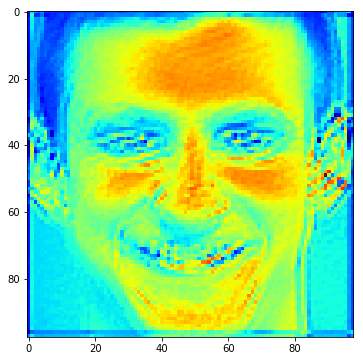

In [123]:
# visualizando a ativação realizado pelos nucleos
idx_nucleo = 0 # primeiro núcleo
fig = plt.figure(figsize=(6,6))
plt.imshow(ativacao_camada_1[:,:,idx_nucleo], cmap='jet')

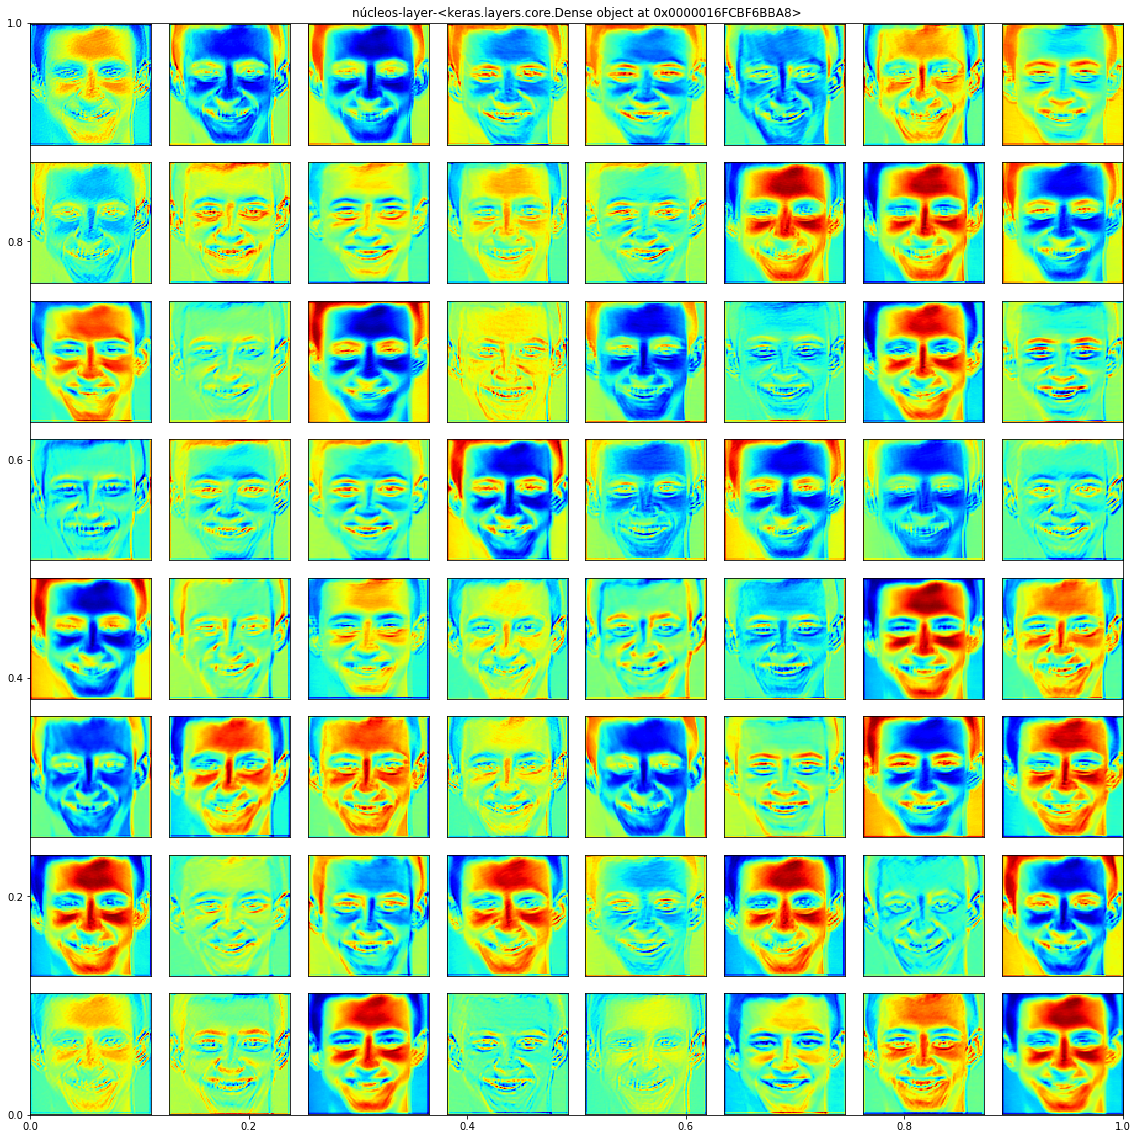

In [133]:
# Visualizando as ativações da imagem através das camadas convoluídas

# Visualizando as ativaçoes de todos núcleos
fig=plt.figure(figsize=(16,16))
plt.title("núcleos-layer-{}".format(layer))
subplot_num=int(np.ceil(np.sqrt(camada1.filters)))

for i in range(camada1.filters):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)

    # Algums mapas de cor: Paired, CMRmap_r, Accent, nipy_spectral, gnuplot, gnuplot2, hot_r, jet, ocean_r, viridis
    ax.imshow(ativacao_camada_1[:,:,i],cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
# para salvar os nucloes em arquivo
fig.savefig("./util/deepemotive-nucleos-{}".format(camada1.name) + '.jpg')

### Visualizando a segunda camada convolucional

In [125]:
# Pegando as ativações da saída da primeira camada de convolucao

camada_nome = 'Bl02_Conv' # segunda camada
camada2 = lista_camadas[camada_nome]
ativacoes_camada2 = get_ativacoes(model, camada2, input_img_data)

In [126]:
# Visualizando o shape da primeira ativação
print(len(ativacoes_camada2))
print(np.shape(ativacoes_camada2)) # (1,1,largura,altura,nucleos) = tensorflow
                                   # (1,1,nucloes,largura,altura) = theano

ativacao_camada_2 = ativacoes_camada2[0][0]
print(ativacao_camada_2.shape)  # (1,largura,altura,nucleos) = tensorflow
                                # (1,nucloes,largura,altura) = theano


1
(1, 1, 45, 45, 128)
(45, 45, 128)


In [127]:
if K.image_dim_ordering() =='th':
    ativacoes_camada2 = np.rollaxis((np.rollaxis(ativacao_camada_2, 2, 0)), 2, 0)
    print('Theano: ',ativacao_camada_2.shape)
print('Tensorflow: ',ativacao_camada_2.shape)

Tensorflow:  (45, 45, 128)


In [128]:
# Quantidade de núcleos
print('Quantidade de núcleos na camada: ',camada2.filters)

Quantidade de núcleos na camada:  128


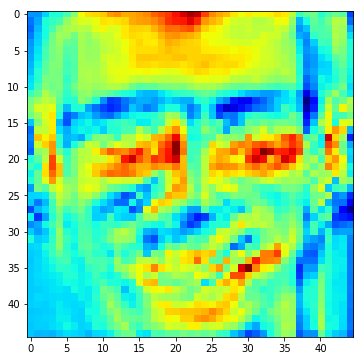

In [129]:
# visualizando a ativação realizado pelos nucleos
idx_nucleo = 0 # primeiro núcleo
fig = plt.figure(figsize=(6,6))
plt.imshow(ativacao_camada_2[:,:,idx_nucleo], cmap='jet')

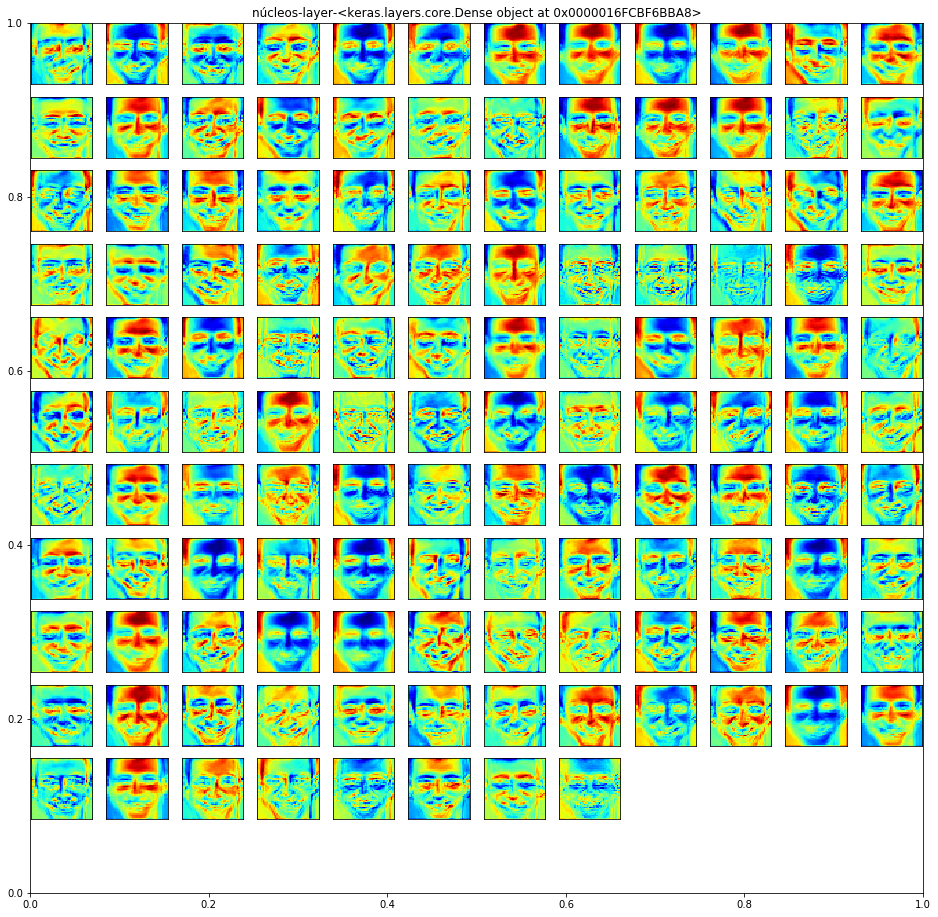

In [132]:
# Visualizando as ativações da imagem através das camadas convoluídas

# Visualizando as ativaçoes de todos núcleos
fig=plt.figure(figsize=(16,16))
plt.title("núcleos-layer-{}".format(layer))
subplot_num=int(np.ceil(np.sqrt(camada2.filters)))

for i in range(camada2.filters):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)

    # Algums mapas de cor: Paired, CMRmap_r, Accent, nipy_spectral, gnuplot, gnuplot2, hot_r, jet, ocean_r, viridis
    ax.imshow(ativacao_camada_2[:,:,i],cmap='jet')
    plt.xticks([])
    plt.yticks([])
    #plt.tight_layout()
plt.show()
# para salvar os nucloes em arquivo
fig.savefig("./util/deepemotive-nucleos-{}".format(camada2.name) + '.jpg')

### Visualizando a terceira camada convolucional

In [134]:
# Pegando as ativações da saída da primeira camada de convolucao

camada_nome = 'Bl03_Conv' # primeira camada
camada3 = lista_camadas[camada_nome]
ativacoes_camada3 = get_ativacoes(model, camada3, input_img_data)

In [135]:
# Visualizando o shape da primeira ativação
print(len(ativacoes_camada3))
print(np.shape(ativacoes_camada3)) # (1,1,largura,altura,nucleos) = tensorflow
                                   # (1,1,nucloes,largura,altura) = theano

ativacao_camada_3 = ativacoes_camada3[0][0]
print(ativacao_camada_3.shape)  # (1,largura,altura,nucleos) = tensorflow
                                # (1,nucloes,largura,altura) = theano

1
(1, 1, 18, 18, 256)
(18, 18, 256)


In [136]:
if K.image_dim_ordering() =='th':
    ativacoes_camada3 = np.rollaxis((np.rollaxis(ativacao_camada_3, 2, 0)), 2, 0)
    print('Theano: ',ativacao_camada_3.shape)
print('Tensorflow: ',ativacao_camada_3.shape)

Tensorflow:  (18, 18, 256)


In [137]:
# Quantidade de núcleos
print('Quantidade de núcleos na camada: ',camada3.filters)

Quantidade de núcleos na camada:  256


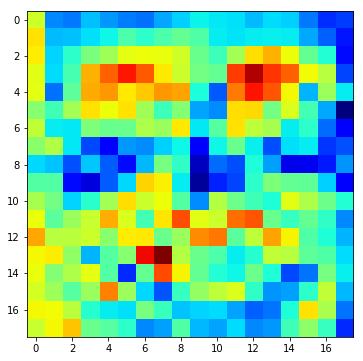

In [138]:
# visualizando a ativação realizado pelos nucleos
idx_nucleo = 0 # primeiro núcleo
fig = plt.figure(figsize=(6,6))
plt.imshow(ativacao_camada_3[:,:,idx_nucleo], cmap='jet')

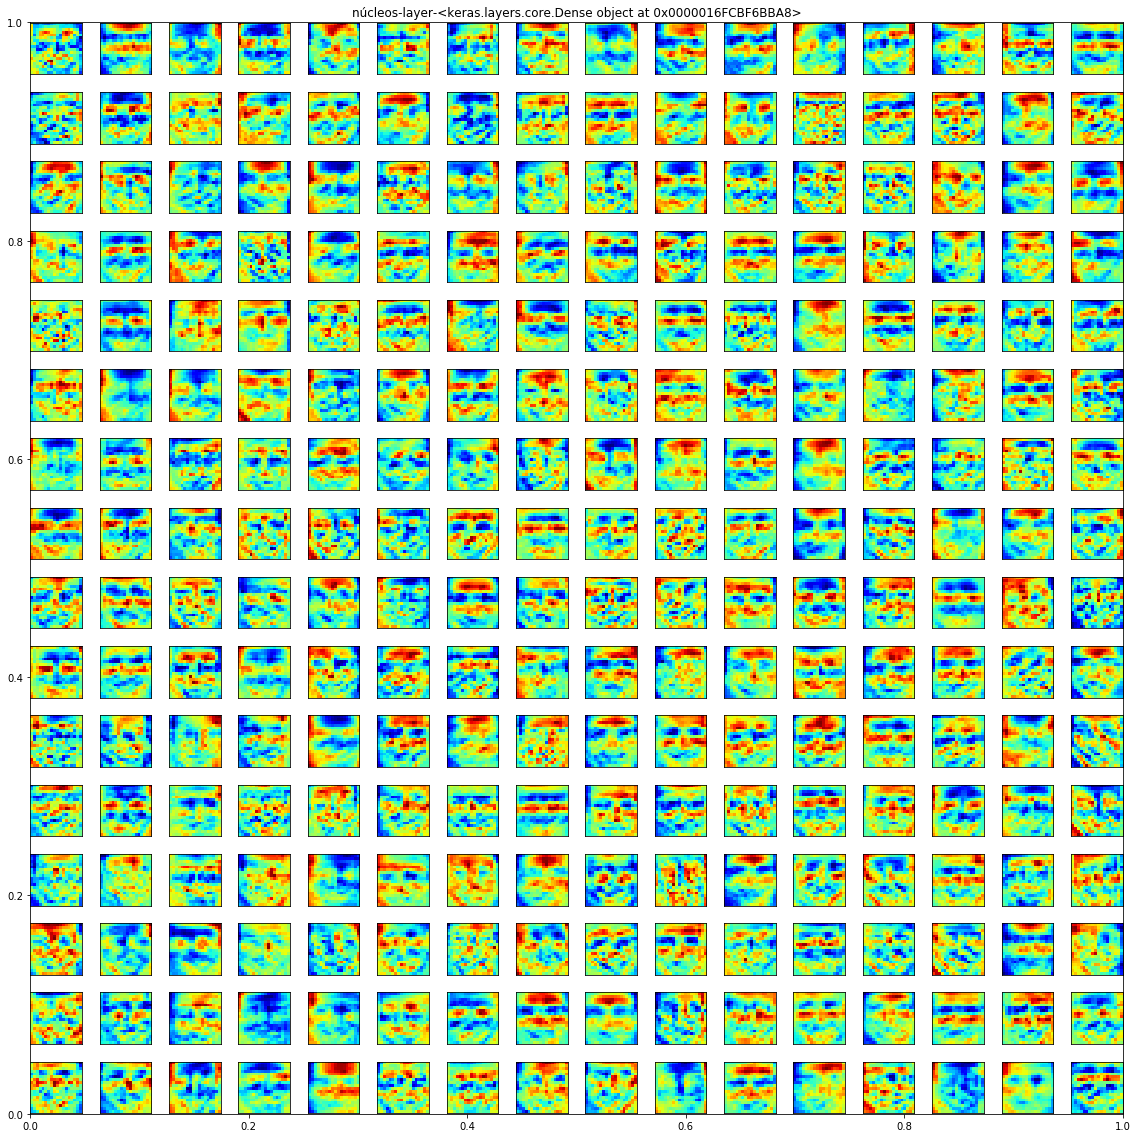

In [139]:
# Visualizando as ativações da imagem através das camadas convoluídas

# Visualizando as ativaçoes de todos núcleos
fig=plt.figure(figsize=(16,16))
plt.title("núcleos-layer-{}".format(layer))
subplot_num=int(np.ceil(np.sqrt(camada3.filters)))

for i in range(camada3.filters):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)

    # Algums mapas de cor: Paired, CMRmap_r, Accent, nipy_spectral, gnuplot, gnuplot2, hot_r, jet, ocean_r, viridis
    ax.imshow(ativacao_camada_3[:,:,i],cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
# para salvar os nucloes em arquivo
fig.savefig("./util/deepemotive-nucleos-{}".format(camada3.name) + '.jpg')